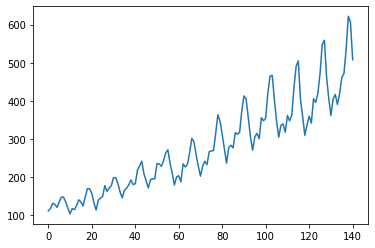

In [3]:
import pandas
import matplotlib.pyplot as plt
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()


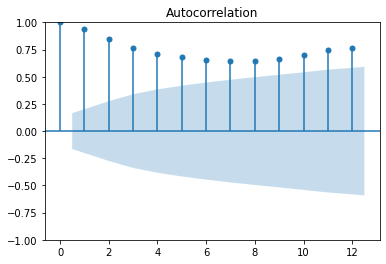

C:\Users\andyc\anaconda3\envs\ai37\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


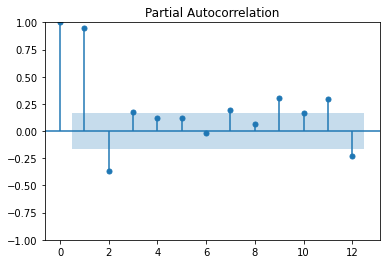

In [5]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
# 畫出 ACF 12 期的效應
sm.graphics.tsa.plot_acf(dataset, lags=12)
plt.show()
# 畫出 PACF 12 期的效應
sm.graphics.tsa.plot_pacf(dataset, lags=12)
plt.show()

Epoch 1/100
92/92 - 1s - loss: 0.0511 - 1s/epoch - 15ms/step
Epoch 2/100
92/92 - 0s - loss: 0.0285 - 100ms/epoch - 1ms/step
Epoch 3/100
92/92 - 0s - loss: 0.0205 - 101ms/epoch - 1ms/step
Epoch 4/100
92/92 - 0s - loss: 0.0183 - 91ms/epoch - 990us/step
Epoch 5/100
92/92 - 0s - loss: 0.0174 - 101ms/epoch - 1ms/step
Epoch 6/100
92/92 - 0s - loss: 0.0166 - 107ms/epoch - 1ms/step
Epoch 7/100
92/92 - 0s - loss: 0.0157 - 118ms/epoch - 1ms/step
Epoch 8/100
92/92 - 0s - loss: 0.0148 - 119ms/epoch - 1ms/step
Epoch 9/100
92/92 - 0s - loss: 0.0136 - 123ms/epoch - 1ms/step
Epoch 10/100
92/92 - 0s - loss: 0.0123 - 123ms/epoch - 1ms/step
Epoch 11/100
92/92 - 0s - loss: 0.0110 - 112ms/epoch - 1ms/step
Epoch 12/100
92/92 - 0s - loss: 0.0096 - 98ms/epoch - 1ms/step
Epoch 13/100
92/92 - 0s - loss: 0.0082 - 99ms/epoch - 1ms/step
Epoch 14/100
92/92 - 0s - loss: 0.0067 - 97ms/epoch - 1ms/step
Epoch 15/100
92/92 - 0s - loss: 0.0056 - 108ms/epoch - 1ms/step
Epoch 16/100
92/92 - 0s - loss: 0.0045 - 119ms/epoch 

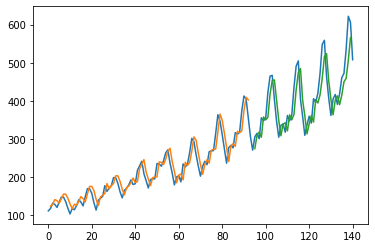

In [9]:
# LSTM for international airline passengers problem with regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


# 產生 (X, Y) 資料集, Y 是下一期的乘客數
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

# 載入訓練資料
dataframe = read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')
# 正規化(normalize) 資料，使資料值介於[0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# 2/3 資料為訓練資料， 1/3 資料為測試資料
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# 產生 (X, Y) 資料集, Y 是下一期的乘客數(reshape into X=t and Y=t+1)
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# 建立及訓練 LSTM 模型
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# 預測
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# 回復預測資料值為原始數據的規模
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate 均方根誤差(root mean squared error)
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# 畫訓練資料趨勢圖
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# 畫測試資料趨勢圖
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# 畫原始資料趨勢圖
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()